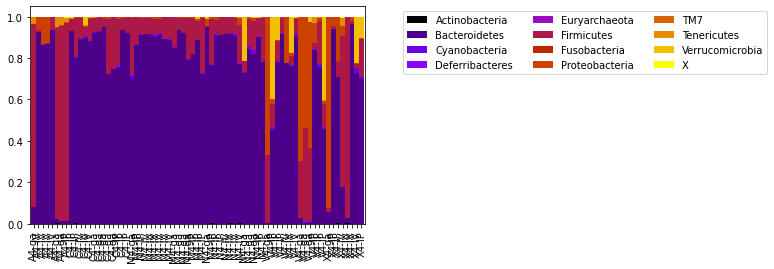

In [2]:
#code for the feces. We gonna read the otulumen and from that get the abundances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tsv_file="otu_table_feces.tsv"
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('otufeces.csv',index=False)
abu0=pd.read_csv("otufeces.csv")
tx0=pd.read_csv("fecestax.csv")
#---------we need to remove the streptomycin samples from the abundamce dataframe
dfA=pd.DataFrame(abu0)
dfA=dfA[dfA.columns.drop(list(dfA.filter(regex='S')))]
dfT=pd.DataFrame(tx0)
#uses the ID on the dfT dataframe, (left), and find it on the df dataframe, (right)
#the dataframe tax_abundance contains all the information: full taxonomy and the values of each sample#
tax_abundance=pd.merge(left=dfT,right=dfA,left_on='ID', right_on='ID')
#-------------------------
#dfA=tax_abundance.set_index('ID').T-->convenient way to transpose keeping the ID in the header
#list the name of columns in the dataframe df
#list(df.columns.values)

#--------------------------
#now we drop the samples that have a total abundance <7000
df=tax_abundance

day0=df[df.columns.drop(list(df.filter(regex='.d1'))+list(df.filter(regex='.d4')))]
day1=df[df.columns.drop(list(df.filter(regex='.d0'))+list(df.filter(regex='.d4')))]
day4=df[df.columns.drop(list(df.filter(regex='.d0'))+list(df.filter(regex='.d1')))]


currentDay=day4

#--------select the antibiotic you wanna plot
filter_col = [col for col in currentDay if col.startswith('A')]
modData=currentDay[['ID']+['Kingdom']+['Phylum']+['Class']+['Order']+['Family']+['Genus']+['Species']+filter_col]
#-----for all antibiotic in the same plot, choose modData=currentDay; For the full, all days, data frame, use modData=df
modData=currentDay
#-----------------

from pandas.api.types import is_numeric_dtype
pd.options.mode.chained_assignment = None  # default='warn'

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        if sum(modData[column]) < 7000:
            modData.drop([column], axis=1, inplace=True)
#----------------------------
#-----now we normalize the samples in such a way each of them adds to 1

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        modData[column]=modData[column]/modData[column].sum()
#------------verification, we can comment this out
#for column in modData.columns[8:]:
#     if is_numeric_dtype(modData[column]):
#        ls=modData.sum(axis=0,skipna=True)
#        #check if everybody is normalized to one
#nd=modData.sum(numeric_only =True )
#for x in range(len(nd)):
#    print(nd[x]),
#---------------------------------


#-----------Block for sample <---> delivery correspondence-------------
#I start at 8 because the previous columns are taxonomy and  ID
headers=list(modData.columns[8:].values)
headers_list = pd.DataFrame(np.column_stack([headers]),columns=['SampleID'])
#------------
#now we convert the metada tsv file into a dataframe we can work with
# we seek a connection between the headers of tax_abundance with the delivery method listed in meta
tsv_file="metadata_feces.tsv"
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('meta_feces.csv',index=False)
m0=pd.DataFrame( pd.read_csv("meta_feces.csv") )
#-----Takes only the first two letters for delivery,e.g.: gavage->ga
#-----Use the single letter definition for antibiotics: A->ampicilin, N->Neomycin, X->mix....
m0['SampleID']=m0['#SampleID']
m0['treat']=m0['SampleID'].apply(lambda x: x[:1])+m0['SampleID'].apply(lambda x: x[-1])+'-'+m0['treatment'].apply(lambda x: x[:2])
meta=m0[['SampleID']+['treat']]
#--------
#--treathead tells us wich delivery was used in each sample. Follows the sample order in modData
treathead=pd.merge(left=headers_list,right=meta,left_on='SampleID', right_on='SampleID')
#deliveryData replaces the .si.lum by the corresponding delivery in each sample
#deliveryData=modData.rename(columns=dict(zip(treathead.SampleID,treathead.treat)))
#-----------------------------------------------------------------------



#----now we tally the samples by desired tax level
#FamilyData= modData.groupby("Family")["Order"].count()--tells us how many orders in the groups of Family
groupData=modData.groupby("Phylum").sum()
lst1=groupData.T

#see how many taxons we have
nentry=groupData.shape[0]
colors = plt.cm.gnuplot(np.linspace(0, 1, nentry))

#lst1.plot(kind='bar',stacked=True,width=1,color=colors).legend(bbox_to_anchor=(1.1, 1.0),ncol=3)


#------------------------------------------
#lst2 is the barchart with the samples headers being the antibiotic with the delivery method
lst2=(lst1.T).rename(columns=dict(zip(treathead.SampleID,treathead.treat))).T
lst2.plot(kind='bar',stacked=True,width=1,color=colors).legend(bbox_to_anchor=(1.1, 1.0),ncol=3)




total=groupData.reset_index()
del total['Phylum']
#renames the columns according to the sample antibiotic and delivery method
total=total.rename(columns=dict(zip(treathead.SampleID,treathead.treat)))
corrtotal=total.corr()


#corrtotal.values.mean()
#entry='V4-IV'

#print(total[entry].corr().values.mean())

#total[entry].corr()
#corrtotal

In [3]:
m0=pd.DataFrame( pd.read_csv("meta_feces.csv") )
#-----Takes only the first two letters for delivery,e.g.: gavage->ga
#-----Use the single letter definition for antibiotics: A->ampicilin, N->Neomycin, X->mix....
m0['SampleID']=m0['#SampleID']
m0['treat']=m0['SampleID'].apply(lambda x: x[:4])+m0['SampleID'].apply(lambda x: x[-1])+'-'+m0['treatment'].apply(lambda x: x[:2])
meta=m0[['SampleID']+['treat']]
#--------
#--treathead tells us wich delivery was used in each sample. Follows the sample order in modData
treathead=pd.merge(left=headers_list,right=meta,left_on='SampleID', right_on='SampleID')
#-----------
group2=modData.groupby(["Phylum"]).sum()
group2


#-----Weighted Unifrac part -- following  http://scikit-bio.org/docs/0.4.1/diversity.html
#for the Unifrac part, the tree representation will be necessary, see http://scikit-bio.org/docs/0.5.1/tree.html
data=(group2.T).to_numpy()

#ids=headers
ids=treathead['treat'].to_list()
from skbio.diversity import alpha_diversity
#compute observed OTUs, an alpha diversity metric, for each sample using the alpha_diversity driver function
adiv_obs_otus = alpha_diversity('observed_otus', data, ids)
#tells us how many non-zeto OTU we have in each sample
adiv_obs_otus

A1.d4-ga    7
A13.4-IV    4
A15.4-IV    4
A16.4-IV    4
A18.4-IV    5
           ..
X14.4-IV    7
X15.4-IV    7
X16.4-IV    8
X18.4-IV    7
X8.d4-IP    9
Length: 71, dtype: int64

In [4]:
group2.T

Phylum,Actinobacteria,Bacteroidetes,Cyanobacteria,Deferribacteres,Euryarchaeota,Firmicutes,Fusobacteria,Proteobacteria,TM7,Tenericutes,Verrucomicrobia,X
A1.d4,0.000151,0.079335,0.000202,0.000000,0.0,0.882560,0.0,0.001714,0.0,0.035786,0.000000,0.000252
A13.d4,0.000000,0.924183,0.000000,0.000000,0.0,0.009003,0.0,0.066024,0.0,0.000790,0.000000,0.000000
A15.d4,0.000000,0.862451,0.000000,0.000000,0.0,0.003737,0.0,0.133372,0.0,0.000440,0.000000,0.000000
A16.d4,0.000000,0.868656,0.000000,0.000141,0.0,0.003519,0.0,0.127684,0.0,0.000000,0.000000,0.000000
A18.d4,0.000000,0.936319,0.000000,0.000000,0.0,0.062164,0.0,0.000885,0.0,0.000158,0.000000,0.000474
...,...,...,...,...,...,...,...,...,...,...,...,...
X14.d4,0.000320,0.176892,0.000000,0.000320,0.0,0.727081,0.0,0.049837,0.0,0.036402,0.000000,0.009148
X15.d4,0.002548,0.024299,0.000000,0.000112,0.0,0.970801,0.0,0.001204,0.0,0.000392,0.000000,0.000644
X16.d4,0.000000,0.962478,0.001248,0.000337,0.0,0.016197,0.0,0.017942,0.0,0.001079,0.000069,0.000651
X18.d4,0.000000,0.728612,0.023208,0.000000,0.0,0.020713,0.0,0.003521,0.0,0.000239,0.223058,0.000649


In [5]:
from skbio import TreeNode
from io import StringIO
tree = TreeNode.read(StringIO("((Actinobacteria,Bacteroidetes,Cyanobacteria, \
                              Deferribacteres,Euryarchaeota,Firmicutes, \
                              Fusobacteria,Proteobacteria,TM7,Tenericutes, \
                              Verrucomicrobia,Other)phylum)AMP;"))
otu_ids=['Actinobacteria', 'Bacteroidetes', 'Cyanobacteria', 'Deferribacteres',
       'Euryarchaeota', 'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'TM7',
       'Tenericutes', 'Verrucomicrobia', 'Other']

#it attributes a length fro the branches. It avoids the error
#-->All non-root nodes in ``tree`` must have a branch length<--
for n in tree.postorder(include_self=True):
    if n.length is None:
        n.length = 0

#comment out the line below to see an interesting tree
#print(tree.ascii_art())
adiv_faith_pd = alpha_diversity('faith_pd', data, ids=ids,
                                 otu_ids=otu_ids, tree=tree)
#adiv_faith_pd

In [58]:
print(tree.ascii_art())

                    /-Actinobacteria
                   |
                   |--Bacteroidetes
                   |
                   |--Cyanobacteria
                   |
                   |--Deferribacteres
                   |
                   |--Euryarchaeota
                   |
                   |--Firmicutes
-AMP----- /phylum--|
                   |--Fusobacteria
                   |
                   |--Proteobacteria
                   |
                   |--TM7
                   |
                   |--Tenericutes
                   |
                   |--Verrucomicrobia
                   |
                    \-Other


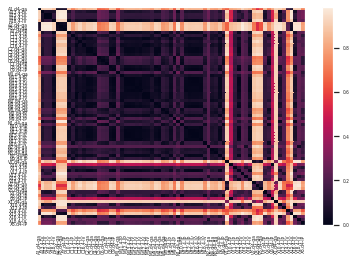

<Figure size 1800x720 with 0 Axes>

In [6]:
#compute Bray-Curtis distances, a beta diversity metric, between all pairs of samples
#I am (on August 12) working with each antibiotic individually
from skbio.diversity import beta_diversity
import seaborn as sns
bc_dm = beta_diversity("braycurtis", data, ids)
sns.set(font_scale=.4)
plt.figure(figsize=(25,10))
bc_dm

In [9]:
#Next, we’ll compute weighted UniFrac distances between all pairs of samples.
#Because weighted UniFrac is a phylogenetic beta diversity metric, we’ll need to
#pass the skbio.TreeNode and list of OTU ids that we created above. 
#Again, these are the same values that were provided to alpha_diversity

#
#wu_dm = beta_diversity("weighted_unifrac", data, ids, tree=tree,
#                        otu_ids=otu_ids)
#print(wu_dm)

In [10]:
#https://machinelearningmastery.com/divergence-between-probability-distributions/
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html

from scipy.spatial import distance
import numpy as np
import seaborn as sns

#the function take(i) take the i-sample in data
#this is necessary for the jensen-shannon distance
def take(i):
    return group2.iloc[:,i].to_numpy()

#gives the jense-shannon distance between samples i and j
def JSdist(i,j):
    return distance.jensenshannon(take(i),take(j))


JSmatrix=np.zeros((len(group2.columns),len(group2.columns)))


for i in range(len(group2.columns)):
    for j in range(len(group2.columns)):
        JSmatrix[i,j]=JSdist(i,j)


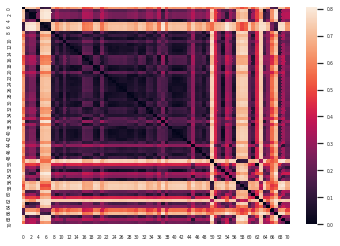

In [11]:
ax=sns.heatmap(JSmatrix)

<Figure size 1080x720 with 0 Axes>

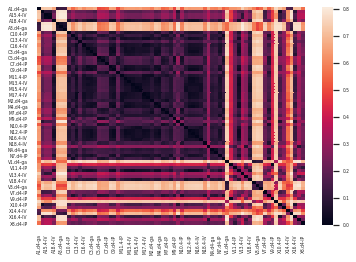

<Figure size 1080x720 with 0 Axes>

In [12]:
ux=pd.DataFrame(JSmatrix)
ux.columns=ids
ux.index=ids

ax=sns.heatmap(ux)
sns.set(font_scale=.7)

plt.figure(figsize=(15,10))